In [1]:
import geopandas
import geopandas as gpd
import pandas as pd
from osgeo import ogr,gdal
import numpy 
from shapely.wkb import loads
import pygeos
import matplotlib.pyplot as plt
import openpyxl
import itertools
import networkx as nx
from simplify import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
gdal.SetConfigOption("OSM_CONFIG_FILE", "osmconf.ini")

def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 

def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id']
    
    
    for a in keyCol: cl.append(a)
    if data is not None:
        for feature in sql_lyr:
            try:
                if feature.GetField(keyCol[0]) is not None:
                    pygeos_geo = pygeos.from_wkt(feature.geometry().ExportToWkt())
                    if pygeos_geo is None:
                        continue
                    # field will become a row in the dataframe.
                    field = []
                    for i in cl: field.append(feature.GetField(i))
                    field.append(pygeos_geo)   
                    features.append(field)
            except:
                print("WARNING: skipped OSM feature")
      
    cl.append('geometry')                   
    if len(features) > 0:
        return geopandas.GeoDataFrame(features,columns=cl) #,crs={'init': 'epsg:4326'}
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return geopandas.GeoDataFrame(columns=['osm_id','geometry']) #,crs={'init': 'epsg:4326'}
    
def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.
    """ 
    return retrieve(osm_path,'lines',['railway','service'])

def subway_network(osm_path):
    df_railway = railway(osm_path)
    subway = df_railway.loc[df_railway.railway == 'subway']
    return subway

def prepare_network(subway):

    df_subway = pd.DataFrame(subway.copy())
    df_subway.geometry = pygeos.from_shapely(df_subway.geometry)
    
    # create mini simplified network and graph of network
    net = Network(edges=df_subway)

    # add nodes to the network
    net = add_endpoints(net)

    # split edges at new nodes
    net = split_edges_at_nodes(net)

    # readd or remove points based on split
    net = add_endpoints(net)

    # give nodes and edges an id
    net = add_ids(net)

    # add topology (Geometry) if still missing
    net = add_topology(net)    

    # add degree
    net.nodes['degree'] = calculate_degree(net)

    # merge edges with degree two
    net = merge_edges(net)

    # remove duplicate edges
    net.edges = drop_duplicate_geometries(net.edges, keep='first') 

    # reset ids based on previous fixes
    net = reset_ids(net) 

    net = add_distances(net)
    net = merge_multilinestrings(net)
    net = add_travel_time(net)
    
    return net.edges,net.nodes

def expand_edges(edges):
    edges['weights'] = edges['distance'].astype(int)
    def pairwise(iterable):
        "s -> (s0, s1), (s1, s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b) 
    edges['to_from'] = list(zip(edges.from_id,edges.to_id))
    edges['from_to'] = list(zip(edges.to_id,edges.from_id))
    return edges

def create_ground_graph(edges, nodes):
    od = edges[['from_id', 'to_id', 'weights']]
    edges_list = []
    for i, row in od.iterrows():
        weight_dict = {"weight": row[2]}
        tuple_row = (row[0], row[1], weight_dict)
        edges_list.append(tuple_row)
    nodes_list = nodes.iloc[:,2].tolist()
    G = nx.Graph()
    G.add_nodes_from(nodes_list)
    G.add_edges_from(edges_list)
    return G

In [3]:
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"

In [4]:
subway = subway_network(osm_path)

<AxesSubplot: >

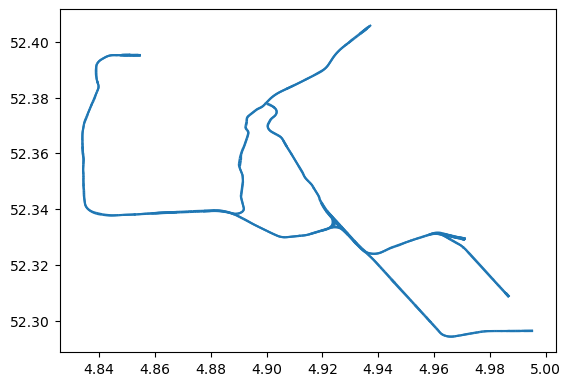

In [5]:
subway.plot()

In [6]:
edges,nodes = prepare_network(subway)

topology: 100%|████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 8960.40it/s]


In [7]:
edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time
0,23157994,"LINESTRING (4.922 52.338, 4.922 52.338, 4.923 ...",subway,NaN,0,294,20,858.377718,0.042919
1,23189033,"LINESTRING (4.846 52.395, 4.847 52.395, 4.847 ...",subway,NaN,1,115,120,237.962864,0.011898
2,23189039,"LINESTRING (4.839 52.386, 4.839 52.386, 4.839 ...",subway,NaN,2,200,115,1320.099057,0.066005
3,23189059,"LINESTRING (4.837 52.377, 4.837 52.378, 4.837 ...",subway,NaN,3,172,201,902.754616,0.045138
4,23189063,"LINESTRING (4.839 52.385, 4.84 52.385, 4.84 52...",subway,NaN,4,191,173,850.965721,0.042548
...,...,...,...,...,...,...,...,...,...
387,1061085945,"LINESTRING (4.922 52.339, 4.922 52.338, 4.922 ...",subway,NaN,387,198,294,34.811758,0.001741
388,1131538376,"LINESTRING (4.921 52.339, 4.921 52.34, 4.921 5...",subway,NaN,388,64,58,348.667904,0.017433
389,1131538382,"LINESTRING (4.922 52.339, 4.921 52.34, 4.921 5...",subway,NaN,389,97,98,350.467868,0.017523
390,1131538383,"LINESTRING (4.92 52.342, 4.92 52.342, 4.92 52....",subway,NaN,390,98,136,307.079253,0.015354


In [8]:
edges = expand_edges(edges)
edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to
0,23157994,"LINESTRING (4.922 52.338, 4.922 52.338, 4.923 ...",subway,NaN,0,294,20,858.377718,0.042919,858,"(294, 20)","(20, 294)"
1,23189033,"LINESTRING (4.846 52.395, 4.847 52.395, 4.847 ...",subway,NaN,1,115,120,237.962864,0.011898,237,"(115, 120)","(120, 115)"
2,23189039,"LINESTRING (4.839 52.386, 4.839 52.386, 4.839 ...",subway,NaN,2,200,115,1320.099057,0.066005,1320,"(200, 115)","(115, 200)"
3,23189059,"LINESTRING (4.837 52.377, 4.837 52.378, 4.837 ...",subway,NaN,3,172,201,902.754616,0.045138,902,"(172, 201)","(201, 172)"
4,23189063,"LINESTRING (4.839 52.385, 4.84 52.385, 4.84 52...",subway,NaN,4,191,173,850.965721,0.042548,850,"(191, 173)","(173, 191)"
...,...,...,...,...,...,...,...,...,...,...,...,...
387,1061085945,"LINESTRING (4.922 52.339, 4.922 52.338, 4.922 ...",subway,NaN,387,198,294,34.811758,0.001741,34,"(198, 294)","(294, 198)"
388,1131538376,"LINESTRING (4.921 52.339, 4.921 52.34, 4.921 5...",subway,NaN,388,64,58,348.667904,0.017433,348,"(64, 58)","(58, 64)"
389,1131538382,"LINESTRING (4.922 52.339, 4.921 52.34, 4.921 5...",subway,NaN,389,97,98,350.467868,0.017523,350,"(97, 98)","(98, 97)"
390,1131538383,"LINESTRING (4.92 52.342, 4.92 52.342, 4.92 52....",subway,NaN,390,98,136,307.079253,0.015354,307,"(98, 136)","(136, 98)"


In [9]:
G = create_ground_graph(edges, nodes)
G

In [10]:
def find_nearest_node(coordinate, nodes):
    """
    Find the nearest node to a given coordinate or geometry in a GeoDataFrame of nodes.

    Args:
    - coordinate: a tuple of longitude and latitude (in decimal degrees) or a PyGEOS geometry object representing the location to search from
    - nodes: a GeoDataFrame containing nodes with a 'geometry' column representing their coordinates as PyGEOS Point objects
    
    Returns:
    - a GeoDataFrame containing the nearest node to the input coordinate or geometry

    Example:
    >>> import geopandas
    >>> from shapely.geometry import Point
    >>> from pygeos import Geometry
    >>> nodes = geopandas.read_file('nodes.shp')
    >>> coordinate = (-122.3, 47.6)
    >>> find_nearest_node(coordinate, nodes)
         id                      geometry
    1234  1234  POINT (-122.29675 47.59605)

    Note: This function requires the PyGEOS and STRtree libraries to be installed.
    """
    # Build an STRtree index of the nodes' geometries for efficient nearest-neighbor search
    node_tree = pygeos.STRtree(nodes.geometry)
    
    # Find the nearest node to the input coordinate or geometry using the STRtree index
    if isinstance(coordinate, tuple):
        find_nearest = node_tree.nearest(pygeos.points(coordinate))
    elif isinstance(coordinate, pygeos.lib.Geometry):
        find_nearest = node_tree.nearest(coordinate)
    
    # Return the node from the nodes GeoDataFrame that corresponds to the nearest index
    return nodes.iloc[find_nearest[1]]

In [ ]:
# def或者和上面的定义合并怎么直接从已知坐标提取出最近点id返回给一个变量
#s_coordinate = (4.978, 52.361)
# s = find_nearest_node(s_coordinate, nodes)
# s_id = s.id
# s_id

In [ ]:
# e_coordinate = (4.881, 52.341)
# e = find_nearest_node(e_coordinate, nodes)
# e

In [ ]:
def shortest_path(G, start_point_id, end_point_id, weight="weight"):
    
    path_s_e = nx.shortest_path(G, source = start_point_id, target = end_point_id, weight = "weight")
    length_s_e = nx.shortest_path_length(G, source = start_point_id, target = end_point_id, weight = "weight")
    print(f"Shortest path from {start_point_id} to {end_point_id}: ", path_s_e)
    print(f"Length of the shortest path from {start_point_id} to {end_point_id}: ", length_s_e)
    def pairwise(iterable):
        "s -> (s0, s1), (s1, s2), (s2, s3), ..."
        a, b = itertools.tee(iterable)
        next(b, None)
        return zip(a, b)
    short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
    short_path_edges['linewidth'] = short_path_edges['weights'].apply(lambda x: np.ceil(x * 0.01 / 2))
    return path_s_e, length_s_e,short_path_edges

In [ ]:
s_id = 45
e_id =106
path_s_e, length_s_e,short_path_edges = shortest_path(G,s_id,e_id,weight="weight")

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(short_path_edges.copy()).plot(ax=ax,color='black',zorder=1)

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(short_path_edges.copy()).plot(ax=ax,color='black',zorder=1,linewidth=short_path_edges['linewidth'])